# Android Data from PlayStore

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Load data
df = pd.read_csv('googleplaystore.csv')
df_user_reviews = pd.read_csv('googleplaystore_user_reviews.csv')
df.columns
df_user_reviews.columns

Index(['App', 'Category', 'Rating', 'Reviews', 'Size', 'Installs', 'Type',
       'Price', 'Content Rating', 'Genres', 'Last Updated', 'Current Ver',
       'Android Ver'],
      dtype='object')

Index(['App', 'Translated_Review', 'Sentiment', 'Sentiment_Polarity',
       'Sentiment_Subjectivity'],
      dtype='object')

In [4]:
# rename columns
df.rename(columns={
    'App': 'name',
    'Category': 'category',
    'Rating': 'rating',
    'Reviews' :'reviews',
    'Size': 'size',
    'Installs': 'installs',
    'Type': 'type',
    'Price': 'price',
    'Content Rating': 'content_rating',
    'Genres': 'genres',
    'Last Updated': 'last_updated',
    'Current Ver': 'version',
    'Android Ver': 'android_version'
    
}, inplace=True)
df.head()

df_user_reviews.rename(
    columns={'App':'app_name', 'Translated_Review': 'review', 'Sentiment': 'sentiment', 'Sentiment_Polarity': 'polarity', 'Sentiment_Subjectivity': 'subjectivity'}
, inplace=True)
df_user_reviews.head()


,name,category,rating,reviews,size,installs,type,price,content_rating,genres,last_updated,version,android_version
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


,app_name,review,sentiment,polarity,subjectivity
0,10 Best Foods for You,I like eat delicious food. That's I'm cooking ...,Positive,1.00,0.533333
1,10 Best Foods for You,This help eating healthy exercise regular basis,Positive,0.25,0.288462
2,10 Best Foods for You,NaN,NaN,NaN,NaN
3,10 Best Foods for You,Works great especially going grocery store,Positive,0.40,0.875000
4,10 Best Foods for You,Best idea us,Positive,1.00,0.300000


In [5]:
orig_df = df.copy()

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10841 entries, 0 to 10840
Data columns (total 13 columns):
name               10841 non-null object
category           10841 non-null object
rating             9367 non-null float64
reviews            10841 non-null object
size               10841 non-null object
installs           10841 non-null object
type               10840 non-null object
price              10841 non-null object
content_rating     10840 non-null object
genres             10841 non-null object
last_updated       10841 non-null object
version            10833 non-null object
android_version    10838 non-null object
dtypes: float64(1), object(12)
memory usage: 1.1+ MB


## Preprocessing
Many columns need preformatting to be able to use them in any machine learning models. They should be converted to numbers.

In [7]:
# there are 1181 duplications in the 'name' column. What should we do about this?
df['name'].duplicated().sum()
# df[df['name'].duplicated()].sort_values('name').head(15)

1181

In [8]:
# preformat installs
df = df[df['installs'] != 'Free']
new_df = df['installs'].map(lambda s : s[:-1].replace(',',''))
new_df[new_df == ''] = 0
new_df.astype(int).unique()
df['installs'] = new_df.astype(int)

array([     10000,     500000,    5000000,   50000000,     100000,
            50000,    1000000,   10000000,       5000,  100000000,
       1000000000,       1000,  500000000,         50,        100,
              500,         10,          1,          5,          0],
      dtype=int64)

In [9]:
# preformat reviews
df['reviews'] = df['reviews'].astype(int)

In [10]:
# preformat size
# np.sort(df['size'].unique())
def size_transform(size):
    if size == 'Varies with device':
        return 1
    unit = size[-1]
    number = float(size[:-1])
    if unit == 'M':
        return number * 1024 * 1024
    if unit == 'k':
        return number * 1024
df['size'] = df['size'].apply(size_transform).astype(int)

In [11]:
# preformat price
# df['price'].unique()
temp_df = df['price'].apply(lambda s: s.replace('$', ''))
temp_df = temp_df.astype(float)
df['price'] = temp_df

In [12]:
# preformat type
df['type'].unique()

# there is one app that doesn't have type -> drop it
# df['type'].isnull().sum()
df.dropna(subset=['type'], inplace=True)
# df['type'].isnull().sum()

# convert 'type' column to category
df['type'] = pd.Categorical(df['type'])

array(['Free', 'Paid', nan], dtype=object)

In [13]:
# preformat category
df['category'] = pd.Categorical(df['category'])

In [14]:
# preformat content_rating
df['content_rating'] = pd.Categorical(df['content_rating'])

In [15]:
# preformat genres
# there are 119 unique genres
df['genres'].nunique()

# keep only the first genre
df['genres'].value_counts().tail(10)

# there are 498 apps that have two genres
df['genres'].str.contains(';').sum()

df['genres'] = df['genres'].str.split(';').str[0]
df['genres'] = pd.Categorical(df['genres'])

# we are down to 48 unique genres
df['genres'].nunique()

119

Card;Brain Games                     1
Adventure;Brain Games                1
Strategy;Creativity                  1
Communication;Creativity             1
Entertainment;Education              1
Travel & Local;Action & Adventure    1
Trivia;Education                     1
Lifestyle;Education                  1
Health & Fitness;Education           1
Comics;Creativity                    1
Name: genres, dtype: int64

498

48

In [16]:
# preformat last_updated -> convert it to difference in days
df['last_updated'] = pd.to_datetime(df['last_updated'])

# consider the max last_updated in df, the date of reference for the other last_updated 
# last_updated will become a negative integer (the number of days between that date and date of reference)
df['last_updated'] = (df['last_updated'] - df['last_updated'].max()).dt.days

## Feature engineering
Features below are derived from the original features of data

In [17]:
# preprocess name
# keep the word count of the app name
df['name_wc'] = df['name'].apply(lambda s : len(s.replace('&','').replace('-', '').split()))

In [18]:
df.head()

,name,category,rating,reviews,size,installs,type,price,content_rating,genres,last_updated,version,android_version,name_wc
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19922944,10000,Free,0.0,Everyone,Art & Design,-213,1.0.0,4.0.3 and up,6
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14680064,500000,Free,0.0,Everyone,Art & Design,-205,2.0.0,4.0.3 and up,3
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,9122611,5000000,Free,0.0,Everyone,Art & Design,-7,1.2.4,4.0.3 and up,10
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,26214400,50000000,Free,0.0,Teen,Art & Design,-61,Varies with device,4.2 and up,3
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2936012,100000,Free,0.0,Everyone,Art & Design,-49,1.1,4.4 and up,6


In [19]:
# preprocess version & android_version
def vs_transform(version):
    if version == 'Varies with device':
        return -1
    if version == np.NaN or version == np.nan:
        return np.nan
    return version[0]
# there are some edge cases that still need to be cared about
# df['version'].astype(str).sort_values()[-1600:]

# df['major_version'] = df['version'].astype(str).apply(vs_transform).astype(int)
# df['android_version'].astype(str).apply(vs_transform).astype(int)

In [20]:
# drop columns not used
drop_columns = ['name', 'version', 'android_version']
df.drop(columns = drop_columns, inplace = True)

In [21]:
df.head()

,category,rating,reviews,size,installs,type,price,content_rating,genres,last_updated,name_wc
0,ART_AND_DESIGN,4.1,159,19922944,10000,Free,0.0,Everyone,Art & Design,-213,6
1,ART_AND_DESIGN,3.9,967,14680064,500000,Free,0.0,Everyone,Art & Design,-205,3
2,ART_AND_DESIGN,4.7,87510,9122611,5000000,Free,0.0,Everyone,Art & Design,-7,10
3,ART_AND_DESIGN,4.5,215644,26214400,50000000,Free,0.0,Teen,Art & Design,-61,3
4,ART_AND_DESIGN,4.3,967,2936012,100000,Free,0.0,Everyone,Art & Design,-49,6


## Missing values

Rating column has 10% missing values. To not lose the data, we try and predict its values using the other features.

In [22]:
# check for null values
# rating has a few
df.isnull().sum()

category             0
rating            1473
reviews              0
size                 0
installs             0
type                 0
price                0
content_rating       0
genres               0
last_updated         0
name_wc              0
dtype: int64

In [23]:
# get the rows with null ratings out, to predict them later
to_predict_rating = df[df['rating'].isnull()]

df = df.dropna()

# Exploratory plots
We plot some data, to see its ranges

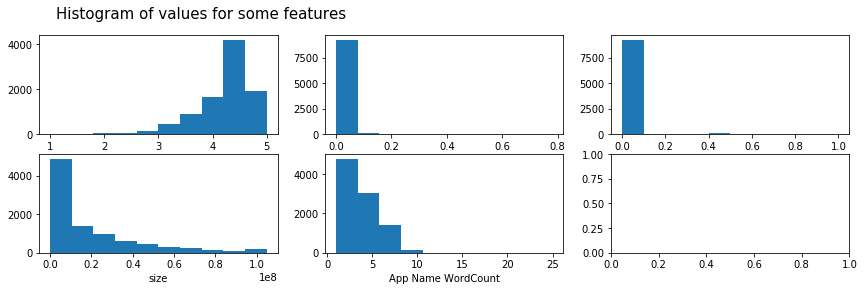

In [24]:
fig, axs = plt.subplots(nrows = 2, ncols = 3);
fig.suptitle('Histogram of values for some features', fontsize = 15);
axs[0][0].hist(df['rating']);
axs[0][0].set_xlabel('rating');
axs[0][1].hist(df['reviews']);
axs[0][1].set_xlabel('reviews');
axs[0][2].hist(df['installs']);
axs[0][2].set_xlabel('installs');
axs[1][0].hist(df['size']);
axs[1][0].set_xlabel('size');
axs[1][1].hist(df['name_wc']);
axs[1][1].set_xlabel('App Name WordCount');
fig.subplots_adjust(right = 2);

### Let's visualize the correlation between features

#### Correlation between "rating" and the other features

<Figure size 1080x360 with 0 Axes>

Text(0, 0.5, 'Correlation to "rating"')

<BarContainer object of 7 artists>

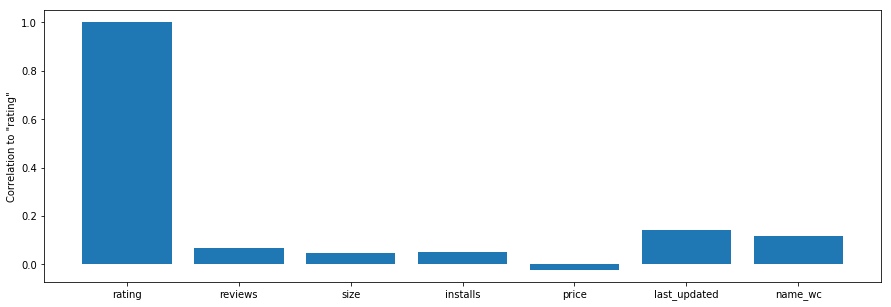

In [25]:
correlation = df.corr()['rating']
plt.figure(figsize=(15,5))
plt.ylabel('Correlation to "rating"')

plt.bar(correlation.index.values, correlation)

**Observations**

- *rating* is correlated the most with *last_year_updated*


#### Correlation between all features

<Figure size 800x640 with 0 Axes>

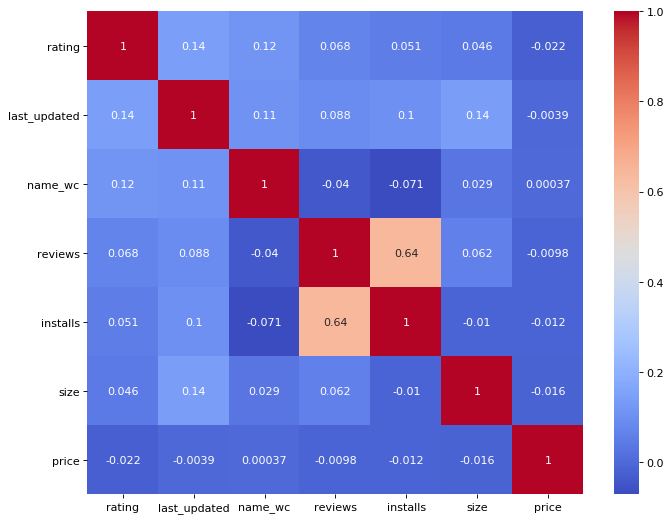

In [26]:
k = len(df.columns.values) #number of variables for heatmap
cols = df.corr().nlargest(k, 'rating')['rating'].index
cm = df[cols].corr()

# enlarge plot
plt.figure(figsize=(10, 8), dpi= 80, facecolor='w', edgecolor='k')

# plot heatmap
sns.heatmap(cm, annot=True, cmap = 'coolwarm')

**Observations**

- *reviews* and *installs* are strongly correlated
- *size* and *last_year_updated* may be somehow related

In [27]:
# Because not all features are preprocessed yet, we got only to use 'Reviews' and 'Installs'. 
# This led to terrible results, like an R squared error of 0.002
# But below you can find an example that find a linear model between 'Reviews' and 'Installs' that works well
# It predicts number of 'Reviews' based on 'Installs' with an R squared error of 0.92 

# A linear model

In [28]:
# convert categorical columns to int so that they can be used by ML models
cat_columns = df.select_dtypes(['category']).columns
cat_columns
df[cat_columns] = df[cat_columns].apply(lambda x: x.cat.codes)

Index(['category', 'type', 'content_rating', 'genres'], dtype='object')

In [29]:
# we use .values because the ML models work with numpy arrays, not pandas dataframes
Y = df['reviews'].values
X = df[['installs']].values

In [30]:
# In some cases we may need to scale data. There are many types of scallers in the preprocessing module. 
# Here is an example

# from sklearn import preprocessing
# scaler = preprocessing.MinMaxScaler()
# X = scaler.fit_transform(X)
# Y = scaler.fit_transform(Y.reshape(-1,1)).squeeze()

In [31]:
# when creating a ML model, we split data in train and test 
# we train the model on the train data and evaluate its performance on the test data
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)

In [32]:
from sklearn import linear_model
lr = linear_model.LinearRegression()
lr.fit(x_train, y_train)
print('Train R squared : %.4f' % lr.score(x_train,y_train))
print('Test R squared : %.4f' % lr.score(x_test,y_test))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

Train R squared : 0.3746
Test R squared : 0.5583


In [33]:
X_log = np.log(X)
Y_log = np.log(Y)
x_train, x_test, y_train, y_test = train_test_split(X_log, Y_log, test_size = 0.2, random_state = 42)

In [34]:
lr.fit(x_train, y_train)
print('Train R squared : %.4f' % lr.score(x_train,y_train))
print('Test R squared : %.4f' % lr.score(x_test,y_test))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

Train R squared : 0.9196
Test R squared : 0.9140


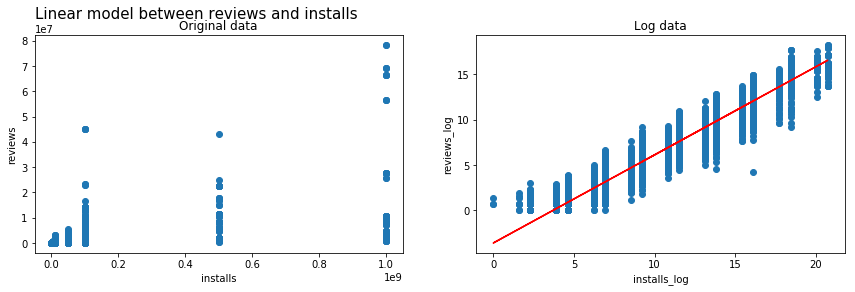

In [35]:
df.columns
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2);
fig.suptitle('Linear model between reviews and installs', fontsize = 15)
fig.subplots_adjust(right = 2)
ax1.set_title('Original data')
ax1.scatter(X, Y);
ax1.set_xlabel('installs');
ax1.set_ylabel('reviews');
ax2.set_title('Log data')
ax2.scatter(X_log[:,0], Y_log);
ax2.set_xlabel('installs_log')
ax2.set_ylabel('reviews_log');
y_pred = lr.predict(X_log)
ax2.plot(X_log[:,0], y_pred, c = 'red');

## Trying other modules

In [36]:
Y = df['rating'].values
X = df[['size', 'installs', 'reviews', 'last_updated', 'name_wc', 'price', 'type']]

In [37]:
from sklearn import svm
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)
svr = svm.SVR()
svr.fit(x_train, y_train)
print('Train score : %.4f' % svr.score(x_train, y_train))
print('Test score : %.4f' % svr.score(x_test, y_test))


D:\Software\anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False)

Train score : 0.8594
Test score : 0.0347
